#### This notebook is adapted from the simulation notebook for crowding and reading.
#### It simulates data for correlation behavioral data with brain data that has already been collected.
Created June 25th, 2025

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import pearsonr, norm, gmean, sem, median_abs_deviation
import matplotlib.ticker as ticker
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
random.seed(42)

# Functions for noise-correction

In [3]:
def compute_noise_ceiling(measurements):
	"""
	Reference: Diedrichsen
	Computes the noise ceiling for a set of repeated measurements.
	Uses split-half reliability across multiple measurements and the geometric mean formula.
	"""
	n_measurements = measurements.shape[1]
	
	first_half = measurements.iloc[:, :n_measurements//2]
	last_half = measurements.iloc[:, n_measurements//2:]
	odd_half = measurements.iloc[:, 1::2]
	even_half = measurements.iloc[:, 0::2]
	
	r_firstLast, _ = pearsonr(np.mean(first_half, axis=1), np.mean(last_half, axis=1))
	r_oddEven, _ = pearsonr(np.mean(odd_half, axis=1), np.mean(even_half, axis=1))

	# Compute the split-half reliability as the geometric mean
	r_i = np.sqrt(r_firstLast * r_oddEven)

	# Apply the extrapolation formula for multiple measurements
	N = 2
	r_m = (N * r_i) / ((r_i * (N - 1)) + 1)

	return r_m

# Simulation parameters (within and between var)

Load in parameters computed in compute_var.ipynb

In [4]:
filepath = '../variance_df.csv'
variance_df = pd.read_csv(filepath)
display(variance_df)


,task,within_subj_variance,btw_subj_variance,mean,r_ceiling
0,crowding,0.015011,0.033836,0.360141,0.899894
1,vernier,0.114137,0.871843,-0.803649,0.937055
2,acuity,0.002199,0.006140,-0.498284,0.835851
3,rsvp,0.039683,0.052974,3.137581,0.625804
4,reading,0.010814,0.025538,2.393177,0.787937
5,V1,0.000556,0.007229,3.448854,0.962393
6,V2,0.000505,0.004018,3.432388,0.940514
7,V3,0.001997,0.005033,3.315249,0.846299
8,V4,0.004003,0.010480,2.947784,0.836813
9,crowding_Ecc5_RL,0.004324,0.017300,0.008261,0.914395


# Functions for simulations

In [5]:
class def_variable_parameters:
	
	def __init__(self, betweenVar, withinVar, mean, learning_factor):
		self.ObsVar = betweenVar
		self.MeasVar = withinVar
		self.Mean = mean
		self.learning_factor = learning_factor

In [6]:
def simulate_psychophysics_data(crowding_params, rsvp_params, n_samples=100, n_measurements=6, correlation = -0.7):
	'''
	Simulates crowding (log Bouma factors) and RSVP reading (log words/min) data
	for specified number of samples and measurements per sample for each task
	
	Returns dataframe containing: the ground truth threshold for each task/participant, each measurement, 
	and the mean of those measurements for each "participant" (sample)
	
	# Parameters for the simulation
	The two required inputs are two objects, 
	each containing the parameters of the x and the y components of this correlation simulation.
	 '''

	# Covariance matrix for the "true" thresholds
	cov_matrix = np.array([
		[crowding_params.ObsVar, correlation * np.sqrt(crowding_params.ObsVar * rsvp_params.ObsVar)],
		[correlation * np.sqrt(crowding_params.ObsVar * rsvp_params.ObsVar), rsvp_params.ObsVar]
	])

	# Simulate "true" thresholds for crowding and RSVP reading
	true_thresholds = np.random.multivariate_normal(
		mean=[crowding_params.Mean, rsvp_params.Mean],
		cov=cov_matrix,
		size=n_samples
	)

	# Extract "true" values for crowding and RSVP
	true_crowding = true_thresholds[:, 0]
	true_rsvp = true_thresholds[:, 1]

	# Initialize a dictionary to store measurements
	data = {
		'crowding_true': true_crowding,
		'rsvp_true': true_rsvp,
	}

	# Simulate noisy measurements for both tasks in a single loop
	# Account for learning in crowding task 
	crowding_measurements = []
	rsvp_measurements = []
	for i in range(n_measurements):
		crowding_noise = np.random.normal(0, np.sqrt(crowding_params.MeasVar), size=n_samples)
		rsvp_noise = np.random.normal(0, np.sqrt(rsvp_params.MeasVar), size=n_samples)
		
		# Calculate noisy measurements 
		crowding_measurement = true_crowding + crowding_noise
		rsvp_measurement = true_rsvp + rsvp_noise
		
		# Increase initial crowding thresholds by learning factor (since learning hasn't yet occurred)
		if i == 0:
			crowding_measurement += 2 * crowding_params.learning_factor
		if i == 1:
			crowding_measurement += crowding_params.learning_factor

		# Add individual measurements to the dictionary
		data[f'crowding_measurement{i+1}'] = crowding_measurement
		data[f'rsvp_measurement{i+1}'] = rsvp_measurement

		# Collect measurements for later averaging
		crowding_measurements.append(crowding_measurement)
		rsvp_measurements.append(rsvp_measurement)

	# Compute the averages of all measurements
	data['crowding_measurement'] = np.mean(crowding_measurements, axis=0)
	data['rsvp_measurement'] = np.mean(rsvp_measurements, axis=0)

	# Create and return the DataFrame
	simulation_data = pd.DataFrame(data)
	return simulation_data

Below we run the simulation 1,000 times for each combo of specified sample sizes and number of measurements. For each round we get the mean difference between the ground truth corr and the corrected corr (using Diedrichsen's noise ceiling method). Then we can plot resulting histograms.

In [7]:
def run_simulation(crowding_param, rsvp_param,
					range_samples=[40, 80, 160, 320], range_measurements=[2, 4, 8, 16], 
					n_repetitions=1000, true_correlation = -0.6):

	hist_corrected_corr = {}
	hist_measured_corr = {}
	results_corr = []

	for n_samples in range_samples:
		for n_meas in range_measurements:
			diff_list_measured = []
			diff_list_corrected = []

			for _ in range(n_repetitions):
				simulation_data = simulate_psychophysics_data(crowding_param, rsvp_param,
															  n_samples, n_meas, correlation = true_correlation)

				crowding_measurements = simulation_data[[f'crowding_measurement{i+1}' for i in range(n_meas)]]
				rsvp_measurements = simulation_data[[f'rsvp_measurement{i+1}' for i in range(n_meas)]]

				r_ceil_crowding = compute_noise_ceiling(crowding_measurements)
				r_ceil_rsvp = compute_noise_ceiling(rsvp_measurements)

				r_ceil = np.sqrt(r_ceil_crowding * r_ceil_rsvp)

				measured_corr, _ = pearsonr(simulation_data['crowding_measurement'], simulation_data['rsvp_measurement'])
				corrected_corr = measured_corr / r_ceil

				diff_list_measured.append(measured_corr - true_correlation)
				diff_list_corrected.append(corrected_corr - true_correlation)

			hist_measured_corr[(n_samples, n_meas)] = diff_list_measured
			hist_corrected_corr[(n_samples, n_meas)] = diff_list_corrected

			rmse_measured = np.sqrt(np.mean([x**2 for x in diff_list_measured])) 
			rmse_corrected = np.sqrt(np.mean([x**2 for x in diff_list_corrected]))

			mean_diff_measured = np.mean(diff_list_measured)
			mean_diff_corrected = np.mean(diff_list_corrected)

			sd_measured = np.std(diff_list_measured)
			sd_corrected = np.std(diff_list_corrected)

			ci_lower_measured, ci_upper_measured = norm.interval(0.95, loc=mean_diff_measured, 
																 scale=np.std(diff_list_measured) / np.sqrt(n_repetitions))
			ci_lower_corrected, ci_upper_corrected = norm.interval(0.95, loc=mean_diff_corrected, 
																   scale=np.std(diff_list_corrected) / np.sqrt(n_repetitions))

			results_corr.append({
				"n_samples": n_samples,
				"n_measurements": n_meas,

				"meanDiff_measured": mean_diff_measured,
				"rmse_measured": rmse_measured,
				"sd_measured": sd_measured,
				"ciLower_measured": ci_lower_measured,
				"ciUpper_measured": ci_upper_measured,

				"meanDiff_corrected": mean_diff_corrected,
				"rmse_corrected": rmse_corrected,
				"sd_corrected": sd_corrected,
				"ciLower_corrected": ci_lower_corrected,
				"ciUpper_corrected": ci_upper_corrected
			})

		print("done with n_samples =",n_samples)

	results_corr_df = pd.DataFrame(results_corr)
   
	return results_corr_df, hist_measured_corr, hist_corrected_corr 

## Functions for plotting the results

In [8]:
def plot_uncorrected_corrected(results_corr_df, x_values, x_subset_name, line_values, line_subset_name, line_label,
							  y_measured_name, y_corrected_name, 
							  x_label, y_label, colors):
	'''
	Inputs:
	- results_corr_df: data frame containing n_samples, n_measurements, and results 
					   such as rmse and sd associated with each number of samples/measurements
	- x_labels:        lists out what we are plotting on the x axis (e.g., n_samples, n_measurements);
	
	'''
	
	plt.figure(figsize=(10, 6))

	for i, ll in enumerate(line_values):
		subset = results_corr_df[results_corr_df[line_subset_name] == ll]

		color = colors[i]
		plt.errorbar(subset[x_subset_name], subset[y_measured_name],
					 fmt='-o', color=color, label=f"{ll} (Uncorrected)")
		plt.errorbar(subset[x_subset_name], subset[y_corrected_name],
					 fmt='--o', color=color, label=f"{ll} (Corrected)")

	plt.axhline(0, color='gray', linestyle='dashed', linewidth=1)
	plt.ylim(-.02,0.25)
	plt.yticks(size=14)
	plt.xlabel(x_label, size=18)
	plt.ylabel(y_label, size=18)
	plt.xscale('log')
	plt.xticks(x_values, labels=x_values, size=14)
	plt.gca().xaxis.set_minor_locator(plt.NullLocator())

	# Keep only one legend entry per sample size
	handles, labels = plt.gca().get_legend_handles_labels()
	unique_labels = list(dict.fromkeys(labels))  # Preserve order but remove duplicates
	unique_handles = [handles[labels.index(label)] for label in unique_labels]

	plt.legend(unique_handles, unique_labels, title=line_label, bbox_to_anchor=(1.05, 1), loc='upper left', title_fontsize=16, fontsize=14)

	plt.tight_layout()
	plt.show()

In [9]:
def plot_sim_results(results_corr_df, plot_items):
	"""
	Plots simulation results based on specified plot items.
	
	Parameters:
	- results_corr_df: DataFrame containing simulation results.
	- plot_items: List of strings specifying what to plot (e.g., ['RMSE', 'Mean diff', 'SD']).
	"""
	sample_sizes = sorted(results_corr_df["n_samples"].unique())
	colors = plt.cm.viridis(np.linspace(0, .7, len(sample_sizes)))  # Use colormap for distinct colors
	n_measurements = sorted(results_corr_df["n_measurements"].unique())

	if 'RMSE' in plot_items:
		plot_uncorrected_corrected(results_corr_df, n_measurements, 'n_measurements', sample_sizes, 'n_samples', 'Sample size',
								   'rmse_measured', 'rmse_corrected',
								   'Number of measurements', 'RMSE', colors)

		plot_uncorrected_corrected(results_corr_df, sample_sizes, 'n_samples', n_measurements, 'n_measurements', 'Num measurements',
								   'rmse_measured', 'rmse_corrected',
								   'Number of samples', 'RMSE', colors)

	if 'Mean diff' in plot_items:
		plot_uncorrected_corrected(results_corr_df, n_measurements, 'n_measurements', sample_sizes, 'n_samples', 'Sample size',
								   'meanDiff_measured', 'meanDiff_corrected',
								   'Number of measurements', 'Mean difference', colors)

		plot_uncorrected_corrected(results_corr_df, sample_sizes, 'n_samples', n_measurements, 'n_measurements', 'Num measurements',
								   'meanDiff_measured', 'meanDiff_corrected',
								   'Number of samples', 'Mean difference', colors)

	if 'SD' in plot_items:
		plot_uncorrected_corrected(results_corr_df, n_measurements, 'n_measurements', sample_sizes, 'n_samples', 'Sample size',
								   'sd_measured', 'sd_corrected',
								   'Number of measurements', 'SD', colors)

		plot_uncorrected_corrected(results_corr_df, sample_sizes, 'n_samples', n_measurements, 'n_measurements', 'Num measurements',
								   'sd_measured', 'sd_corrected',
								   'Number of samples', 'SD', colors)

In [10]:
def plot_histograms(hist_corr, corr_type = "Uncorrected"):
	"""
	Plots histograms of differences in correlation values for different sample and measurement conditions.
	
	Parameters:
	hist_corr (dict): A dictionary where keys are tuples (n_samples, n_measurements),
					  and values are lists/arrays of differences.
	corr_type (str): either "Uncorrected" or "Corrected"
	"""
	for (n_samples, n_measurements), differences in hist_corr.items():
		mean_diff = np.mean(differences)
		sd = np.std(differences)

		plt.figure(figsize=(5, 4))
		plt.hist(differences, bins=20, alpha=0.7, edgecolor='black')

		# Add vertical lines for mean and standard deviation
		plt.axvline(mean_diff, color='red', linestyle='dashed', linewidth=2, label=f"Mean: {mean_diff:.3f}")
		plt.axvline(mean_diff - sd, color='blue', linestyle='dashed', linewidth=2, label=f"SD: {sd:.3f}")
		plt.axvline(mean_diff + sd, color='blue', linestyle='dashed', linewidth=2)
		plt.axvline(0, color='black', linestyle='dashed', linewidth=3)

		# Formatting
		plt.xlim(-0.6, 0.6)
		plt.xlabel(f"{corr_type}-Sample R")
		plt.ylabel("Frequency")
		plt.title(f"Samples={n_samples}, Measurements={n_measurements}")
		plt.legend()
		plt.show()

# Run simulations

## EE crowding, EE RSVP

In [11]:
# Run simulation
learning_factor_logCrowding = 0.05
crowding_ee_param = def_variable_parameters(betweenVar = variance_df[variance_df['task'] == 'crowding']['btw_subj_variance'].values[0], 
										 withinVar = variance_df[variance_df['task'] == 'crowding']['within_subj_variance'].values[0], 
										 mean = variance_df[variance_df['task'] == 'crowding']['mean'].values[0], 
										 learning_factor = learning_factor_logCrowding)

rsvp_param = def_variable_parameters(betweenVar = variance_df[variance_df['task'] == 'rsvp']['btw_subj_variance'].values[0], 
									 withinVar = variance_df[variance_df['task'] == 'rsvp']['within_subj_variance'].values[0], 
									 mean = variance_df[variance_df['task'] == 'rsvp']['mean'].values[0], 
									 learning_factor = 0)

results_corr_df, hist_measured_corr, hist_corrected_corr = run_simulation(crowding_ee_param, rsvp_param)

done with n_samples = 40
done with n_samples = 80
done with n_samples = 160
done with n_samples = 320


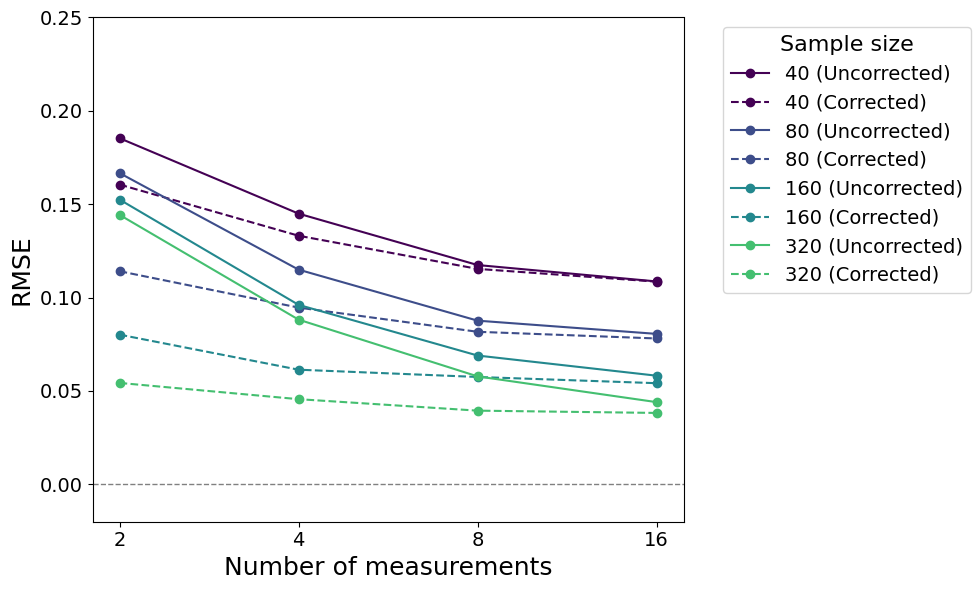

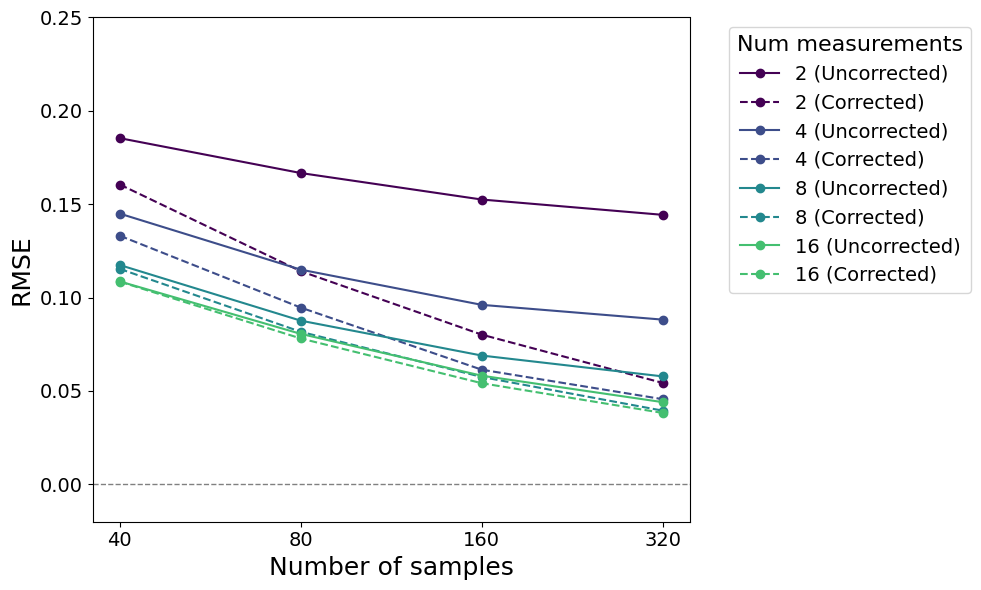

In [12]:
plot_sim_results(results_corr_df, ['RMSE'])

## EE crowding, V4

In [ ]:
# Run simulation
learning_factor_logCrowding = 0.05
crowding_ee_param = def_variable_parameters(betweenVar = variance_df[variance_df['task'] == 'crowding']['btw_subj_variance'].values[0], 
										 withinVar = variance_df[variance_df['task'] == 'crowding']['within_subj_variance'].values[0], 
										 mean = variance_df[variance_df['task'] == 'crowding']['mean'].values[0], 
										 learning_factor = learning_factor_logCrowding)

v4_param = def_variable_parameters(betweenVar = variance_df[variance_df['task'] == 'V4']['btw_subj_variance'].values[0], 
									 withinVar = variance_df[variance_df['task'] == 'V4']['within_subj_variance'].values[0], 
									 mean = variance_df[variance_df['task'] == 'V4']['mean'].values[0], 
									 learning_factor = 0)

results_corr_df, hist_measured_corr, hist_corrected_corr = run_simulation(crowding_ee_param, v4_param, true_correlation = -0.65)

done with n_samples = 40
done with n_samples = 80
done with n_samples = 160
done with n_samples = 320


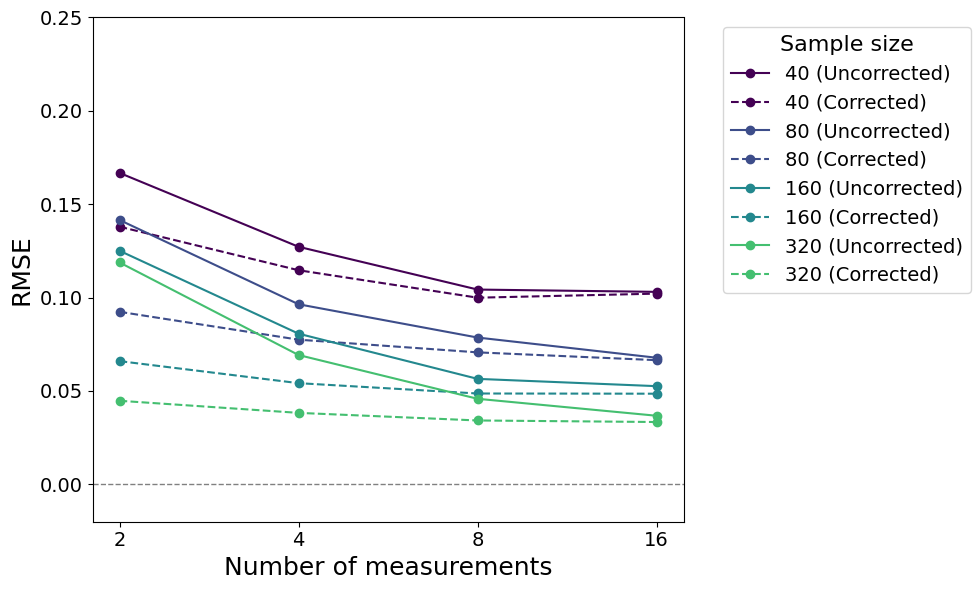

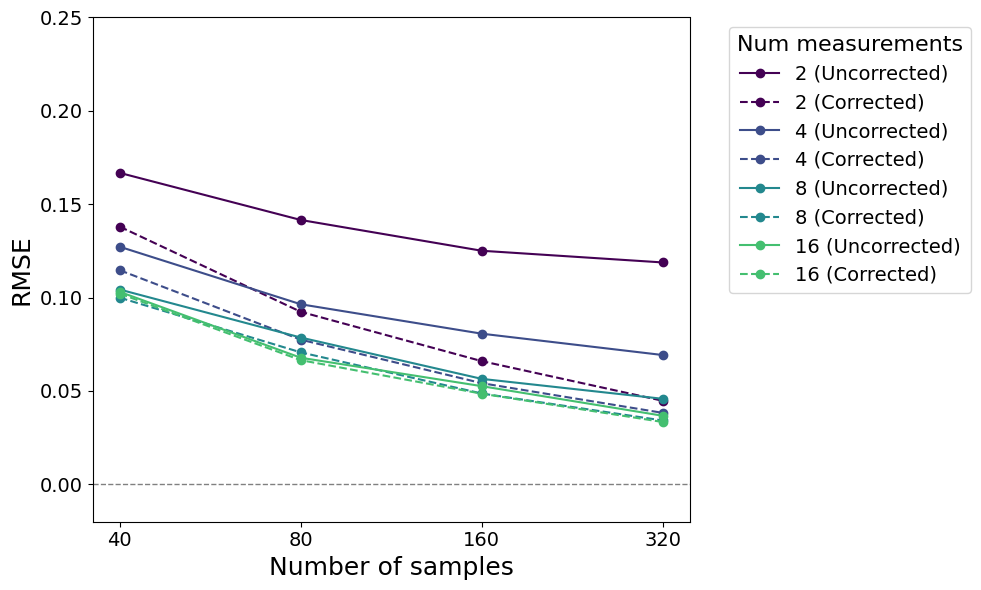

In [14]:
plot_sim_results(results_corr_df, ['RMSE'])

## NatCom crowding, V4

In [17]:
# Run simulation
crowding_natcom_param = def_variable_parameters(betweenVar = variance_df[variance_df['task'] == 'crowding_Ecc10_RL']['btw_subj_variance'].values[0], 
												withinVar = variance_df[variance_df['task'] == 'crowding_Ecc10_RL']['within_subj_variance'].values[0], 
												mean = variance_df[variance_df['task'] == 'crowding_Ecc10_RL']['mean'].values[0], 
												learning_factor = 0)

results_corr_df, hist_measured_corr, hist_corrected_corr = run_simulation(crowding_natcom_param, v4_param, true_correlation= -0.65)

done with n_samples = 40
done with n_samples = 80
done with n_samples = 160
done with n_samples = 320


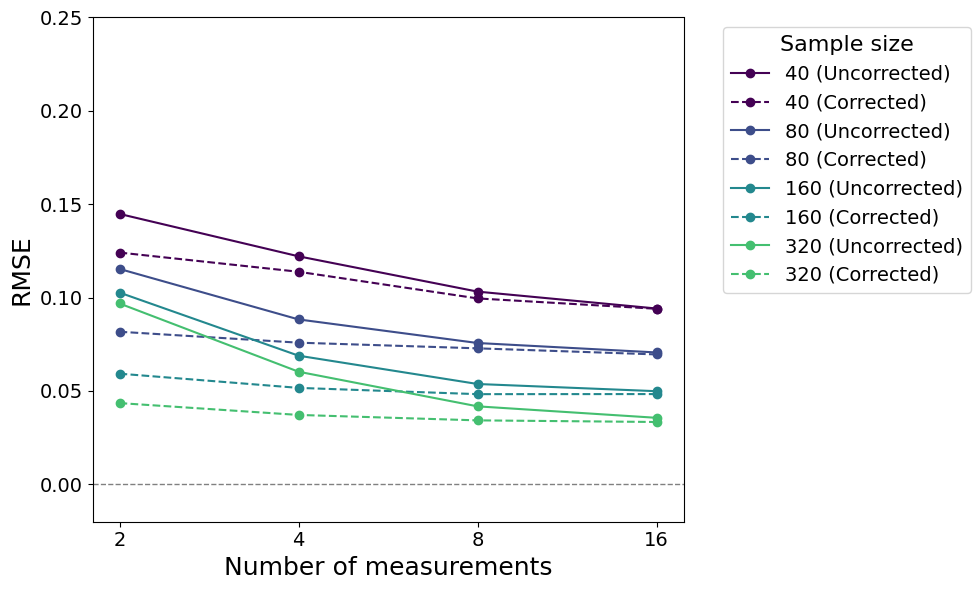

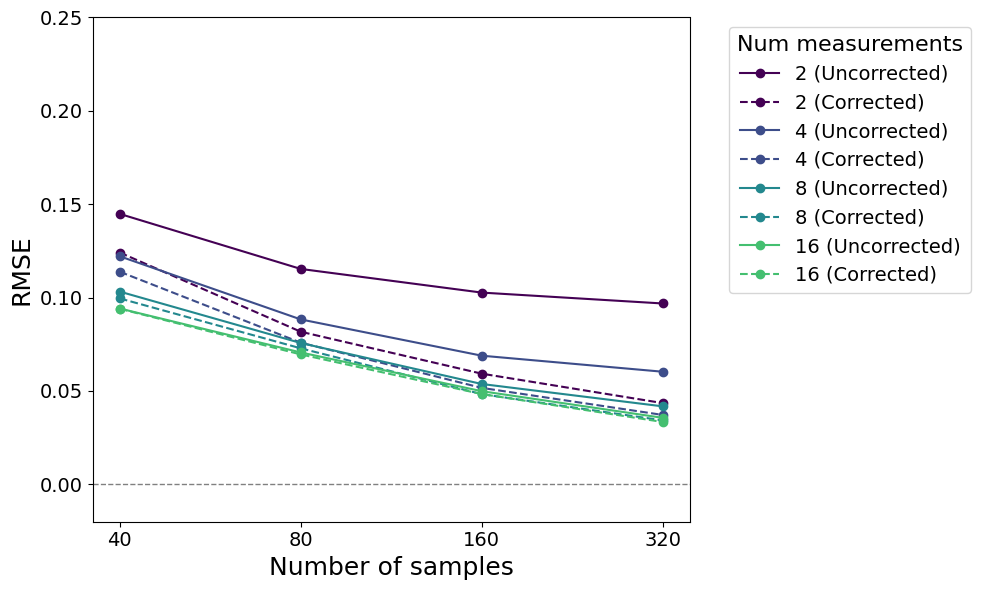

In [18]:
plot_sim_results(results_corr_df, ['RMSE'])

## EE Vernier, V1

In [19]:
vernier_ee_param = def_variable_parameters(betweenVar = variance_df[variance_df['task'] == 'vernier']['btw_subj_variance'].values[0], 
										 withinVar = variance_df[variance_df['task'] == 'vernier']['within_subj_variance'].values[0], 
										 mean = variance_df[variance_df['task'] == 'vernier']['mean'].values[0], 
										 learning_factor = learning_factor_logCrowding)
v1_param = def_variable_parameters(betweenVar = variance_df[variance_df['task'] == 'V1']['btw_subj_variance'].values[0], 
									 withinVar = variance_df[variance_df['task'] == 'V1']['within_subj_variance'].values[0], 
									 mean = variance_df[variance_df['task'] == 'V1']['mean'].values[0], 
									 learning_factor = 0)

results_corr_df, hist_measured_corr, hist_corrected_corr = run_simulation(vernier_ee_param, v1_param, true_correlation = -0.5)

done with n_samples = 40
done with n_samples = 80
done with n_samples = 160
done with n_samples = 320


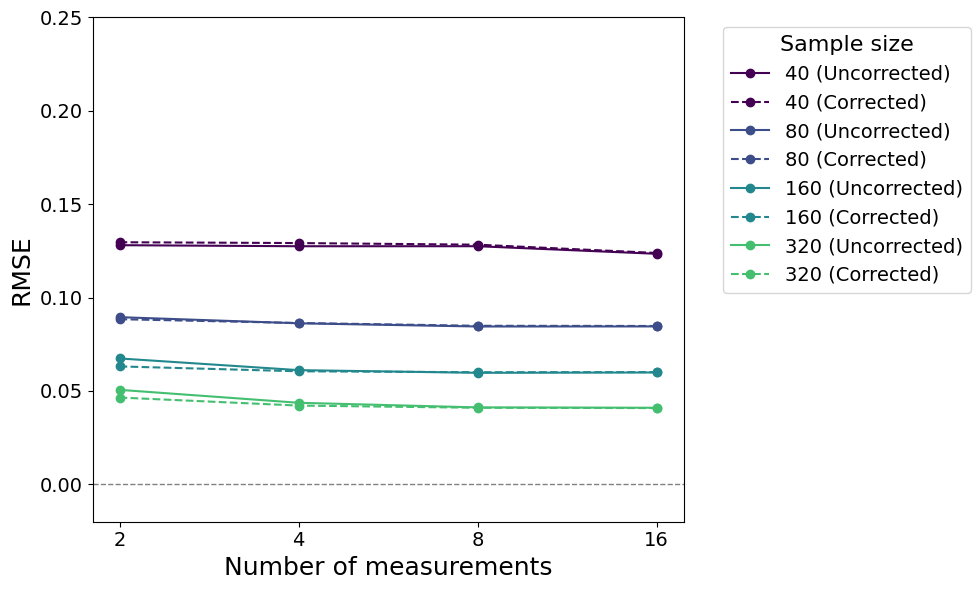

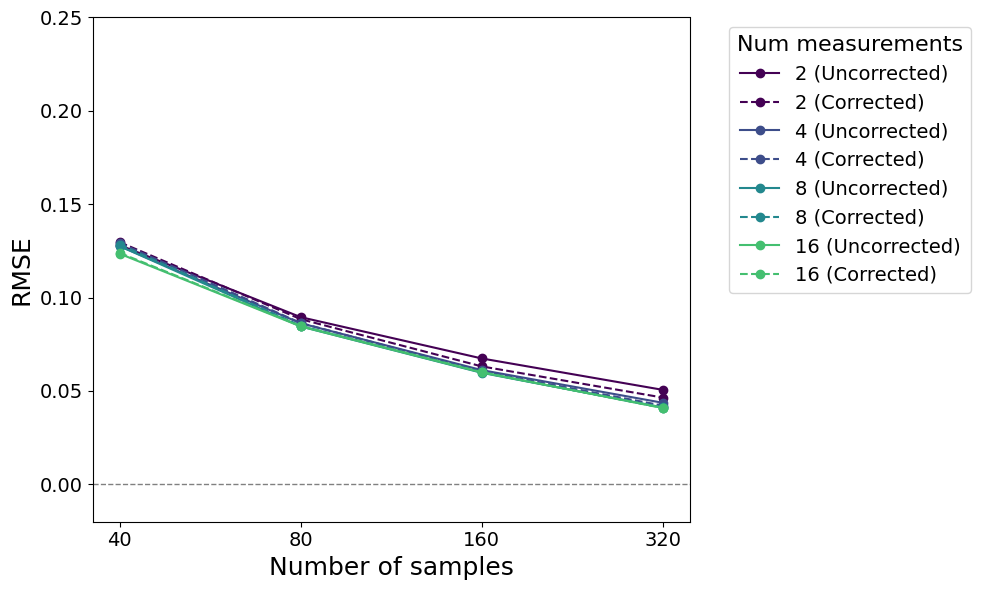

In [20]:
plot_sim_results(results_corr_df, ['RMSE'])